In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "domain_size_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "domain_size_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
test_filename = "domain_size_benchmark_run_0.txt"
print("Storing data in " + test_filename)

Storing data in domain_size_benchmark_run_0.txt


In [3]:
def runBenchmark(filename):
    sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    domain_size = np.array([256, 512, 1024, 2048, 3192, 4096, 5192, 6144])
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for i in range(domain_size.shape[0]):

                tic = time.time()

                test_file.write("=========================================\n")
                test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(domain_size[i], domain_size[i]))
                test_file.write("-----------------------------------------\n")
                cmd = [ "python", "run_benchmark.py", "--nx", str(domain_size[i]), "--ny", str(domain_size[i]), "--simulator", sim[k], "--steps_per_download", "1000"]
                p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                output = p.stdout.read()
                test_file.write(output + "\n")
                test_file.write("=========================================\n")
                test_file.write("\n")

                toc = time.time()

                infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(domain_size[i], domain_size[i], (toc-tic))
                test_file.write(infostr)
                test_file.flush()
                os.fsync(test_file)
                print(infostr[:-1])
                    
            test_file.write("\n\n\n")


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Using existing run in domain_size_benchmark_run_0.txt


In [4]:
def getData(filename):
    # State variables
    simulator = None
    domain_size = None

    data = np.empty((0, 3))

    with open(filename) as origin_file:
        for line in origin_file:

            # Find simulator
            match = re.findall(r'(Using simulator)', line)
            if match:
                simulator = line.split(' ')[2][:-2]

            # Find block size
            match = re.findall(r'(Running with domain size)', line)
            if match:
                domain_size = line.split(' ')[5][1:]

            # Find simulator megacells
            match = re.findall(r'(Maximum megacells)', line)
            if match:
                megacells = float(line.split(' ')[4])
                data = np.append(data, [[simulator, domain_size, megacells]], axis=0)
                
                domain_size = None

    return data

data = getData(test_filename)
print(data)

[['FBL' '256' '53.85045159']
 ['FBL' '512' '218.27144497']
 ['FBL' '1024' '867.30844008']
 ['FBL' '2048' '2022.32582304']
 ['FBL' '3192' '1970.38561061']
 ['FBL' '4096' '1990.65211831']
 ['CTCS' '256' '31.29704121']
 ['CTCS' '512' '124.77105721']
 ['CTCS' '1024' '501.23135572']
 ['CTCS' '2048' '737.91414299']
 ['CTCS' '3192' '742.24987262']
 ['CTCS' '4096' '735.32678871']
 ['KP' '256' '84.56257024']
 ['KP' '512' '338.25028096']
 ['KP' '1024' '454.32233975']
 ['KP' '2048' '458.79501404']
 ['KP' '3192' '443.95921938']
 ['KP' '4096' '432.9157254']
 ['CDKLM' '256' '75.41542366']
 ['CDKLM' '512' '299.25108487']
 ['CDKLM' '1024' '317.46170405']
 ['CDKLM' '2048' '320.98446684']
 ['CDKLM' '3192' '310.36169244']
 ['CDKLM' '4096' '311.46207291']]


In [19]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       cycler('markersize', [6, 6, 10, 8, 8, 8]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

CDKLM
CTCS
FBL
KP


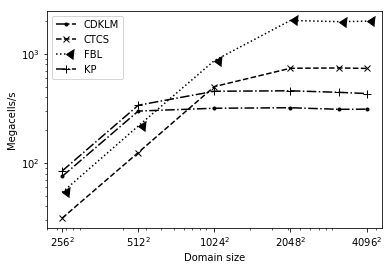

In [22]:
simulators = np.unique(data[:,0])

fig = plt.figure()
setBwStyles(fig.gca())

for simulator in simulators:
    print(simulator)
    
    columns = data[:,0] == simulator
    
    domain_sizes = data[columns,1].astype(np.float32)
    megacells = data[columns,2].astype(np.float32)
    
    plt.loglog(domain_sizes*domain_sizes, megacells, label=simulator)

plt.legend()

print_domain_sizes = np.array([256, 512, 1024, 2048, 4096])
plt.xticks( print_domain_sizes*print_domain_sizes, map(lambda x: "$" + str(x) + "^2$", print_domain_sizes ) )
plt.xlabel("Domain size")
plt.ylabel("Megacells/s")
plt.savefig("Performance.pdf")